In [1]:
import numpy as np
import glob, os
import xarray as xr
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import shapely.geometry as sgeom
import matplotlib.patheffects as path_effects
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
topfile = '/global/project/projectdirs/m1867/zfeng/globe_topography/ETOPO1_Ice_g_gmt4.nc'
# topfile_csapr = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
topfile_csapr = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/CACTI_Domain_30m.Surface_Elevation.nc'

figdir = '/global/project/projectdirs/m1657/zfeng/cacti/imerg/results/'
figdir_csapr = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/'

In [4]:
dstop = xr.open_dataset(topfile)
dstop

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

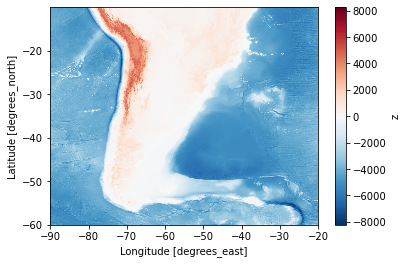

In [5]:
# Crop South America region
ter = dstop.z.sel(x=slice(-90,-20), y=slice(-60,-10))
lon = dstop.x.sel(x=slice(-90,-20))
lat = dstop.y.sel(y=slice(-60,-10))
landmask = ter >= 0
ter.plot()

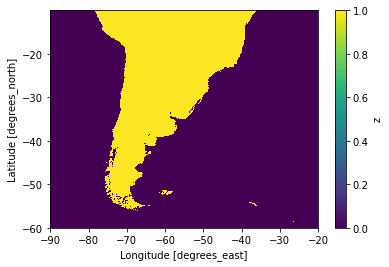

In [6]:
landmask.plot()

In [7]:
dsc = xr.open_dataset(topfile_csapr)
dsc

<xarray.Dataset>
Dimensions:    (latitude: 10801, longitude: 10801)
Coordinates:
  * latitude   (latitude) float32 -31.0 -31.0 -31.0 -31.0 ... -34.0 -34.0 -34.0
  * longitude  (longitude) float32 -66.0 -66.0 -66.0 -66.0 ... -63.0 -63.0 -63.0
Data variables:
    height     (latitude, longitude) float32 ...
Attributes:
    description:  Stitched together from the 30-m ASTER_GDEM dataset (https:/...
    contact:      Adam Varble, adam.varble@pnnl.gov
    date:         13 April 2021

In [8]:
# Coarsen the terrain data by 10x
# dscc = dsc.coarsen(x=10, y=10, boundary='trim', keep_attrs=True).mean()
dscc = dsc.coarsen(longitude=5, latitude=5, boundary='trim', keep_attrs=True).mean()
dscc

<xarray.Dataset>
Dimensions:    (latitude: 2160, longitude: 2160)
Coordinates:
  * latitude   (latitude) float32 -31.0 -31.0 -31.0 -31.0 ... -34.0 -34.0 -34.0
  * longitude  (longitude) float32 -66.0 -66.0 -66.0 -66.0 ... -63.0 -63.0 -63.0
Data variables:
    height     (latitude, longitude) float32 372.4 371.9 371.8 ... 132.9 129.4
Attributes:
    description:  Stitched together from the 30-m ASTER_GDEM dataset (https:/...
    contact:      Adam Varble, adam.varble@pnnl.gov
    date:         13 April 2021

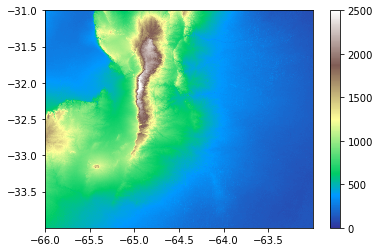

In [9]:
# dscc.height.plot(cmap='terrain')
plt.pcolormesh(dscc.longitude, dscc.latitude, dscc.height, shading='auto', vmin=0, vmax=2500, cmap='terrain')
plt.colorbar()

In [10]:
# lon_wrfbox = [-72.9671, -52.43289, -52.43289, -72.9671, -72.9671]
# lat_wrfbox = [-38.34014, -38.34014, -24.947563, -24.947563, -38.34014]

In [11]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [12]:
def compute_radius(proj, lat, lon, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = proj.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

In [13]:
def calc_latlon(lon1, lat1, dist, angle):
    """
    Haversine formula to calculate lat/lon locations from distance and angle.
    
    lon1:   longitude in [degree]
    lat1:   latitude in [degree]
    dist:   distance in [km]
    angle:  angle in [degree]
    """

    import math

    # Earth radius
    # R_earth = 6378.39  # at Equator [km]
    R_earth = 6374.2  # at 40 degree latitude [km]
#     R_earth = 6356.91  # at the pole [km]

    # Conver degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(angle)

    lat2 = math.asin(math.sin(lat1) * math.cos(dist/R_earth) +
                     math.cos(lat1) * math.sin(dist/R_earth) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(dist/R_earth) * math.cos(lat1),
                             math.cos(dist/R_earth) - math.sin(lat1) * math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lon2, lat2

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9cdb4f0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9cdb680> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x2aaad9dfdf90> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coord

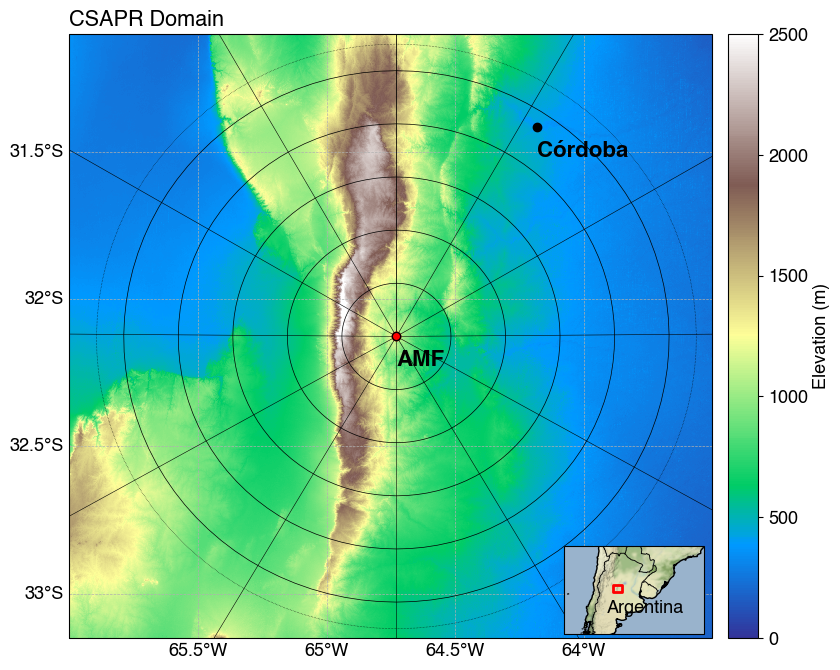

In [17]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -66
lonmax = -63.5
latmin = -33.15
latmax = -31.1
map_extend = [lonmin, lonmax, latmin, latmax]
lonvals = mpl.ticker.FixedLocator(np.arange(-70,-60.1,0.5))
latvals = mpl.ticker.FixedLocator(np.arange(-40,-30.1,0.5))

fig = plt.figure(figsize=[10,8], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
# ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
ax.set_aspect('auto', adjustable=None)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,2500.1,10)
cbticks = np.arange(0,2500.1,500)
cmap = plt.get_cmap('terrain')
# cmap = truncate_colormap(cmap, 0.22, 1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
cf = plt.pcolormesh(dscc.longitude, dscc.latitude, dscc.height, shading='nearest', 
                    norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# cf = plt.pcolormesh(dsc.x, dsc.y, dsc.z, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# cf = ax.contourf(dsc.x, dsc.y, dsc.z, levels=levels, cmap=cmap, transform=proj)
cb = plt.colorbar(cf, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('CSAPR Domain', loc='left')

radii = np.arange(20,101,20)  # radii for the range rings [km]
azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location
cor_lon, cor_lat = -64.183333, -31.416667  # Cordoba city location

ax.plot(radar_lon, radar_lat, color='red', marker='o', markersize=6, zorder=10)
ax.plot(radar_lon, radar_lat, color='k', marker='o', markersize=6, fillstyle='none', zorder=10)
ax.text(radar_lon, radar_lat-0.1, 'AMF', color='k', fontsize=16, fontweight='bold', zorder=10)
ax.plot(cor_lon, cor_lat, color='k', marker='o', markersize=6, zorder=10)
ax.text(cor_lon, cor_lat-0.1, 'Córdoba', color='k', fontsize=16, fontweight='bold', zorder=10)

# Plot range circles around radar
for ii in range(0, len(radii)):
    rr = ax.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', lw=0.5, zorder=3)
rr = ax.tissot(rad_km=110, lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', ls=':', lw=0.4, zorder=3)
# Plot azimuth lines
for ii in range(0, len(azimuths)):
    lon2, lat2 = calc_latlon(radar_lon, radar_lat, 150, azimuths[ii])
    ax.plot([radar_lon,lon2], [radar_lat,lat2], color='k', lw=0.4, transform=proj, zorder=5)
    
# Create an inset GeoAxes showing the location of the domain
sub_ax = plt.axes([0.62, 0.06, 0.14, 0.25], projection=proj)
sub_ax.set_extent([-80, -40, -45, -20], proj)
# # Make a nice border around the inset axes.
# effect = path_effects.Stroke(linewidth=4, foreground='wheat', alpha=0.5)
# sub_ax.outline_patch.set_path_effects([effect])
    
# Add land, coastlines, borders to inset
# sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k', zorder=4)
sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
# sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'], zorder=4)
sub_ax.add_feature(borders, edgecolor='k', facecolor='none', lw=0.6, zorder=4)
# Add the Stamen data at zoom level X (larger number is higher resolution).
stamen_terrain = cimgt.Stamen('terrain-background')
sub_ax.add_image(stamen_terrain, 4)
# Add CSAPR domain box
csapr_domain = sgeom.box(minx=map_extend[0], maxx=map_extend[1], miny=map_extend[2], maxy=map_extend[3])
sub_ax.add_geometries([csapr_domain], proj, facecolor='none', edgecolor='r', lw=2, zorder=5)
sub_ax.text(-68, -39, 'Argentina', color='k', fontsize=13, ha='left', zorder=5)

figname = f'{figdir_csapr}CACTI_CSAPR_terrain_map.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [15]:
f'{figdir_csapr}CACTI_CSAPR_terrain_map.png'

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/corgridded_terrain.c0/CACTI_CSAPR_terrain_map.png'

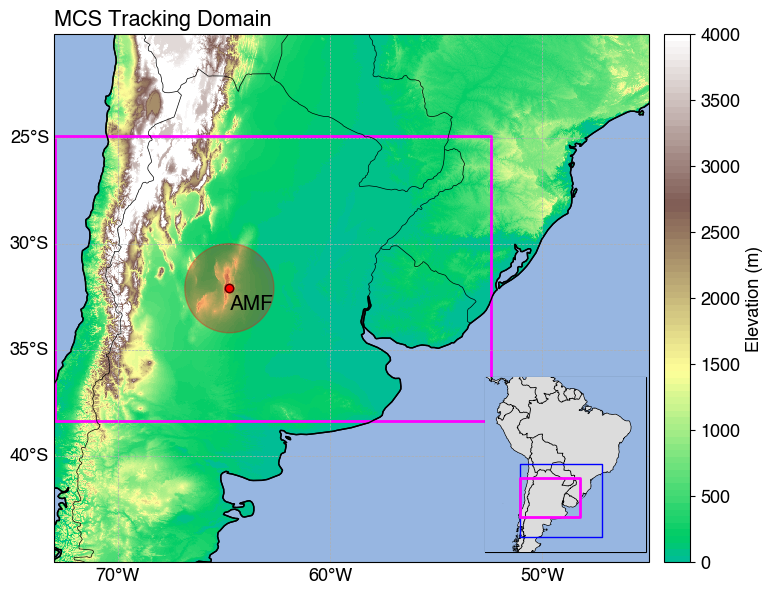

In [12]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -73
lonmax = -45
latmin = -45
latmax = -20.1
# map_extend = [-73, -45.1, -45, -20.1]
map_extend = [lonmin, lonmax, latmin, latmax]

lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,5))
levelshgt = [1000,2000]

fig = plt.figure(figsize=[10,7], dpi=100)
# fig = plt.figure(figsize=[15,5], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
gl.top_labels = False
gl.right_labels = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,4000.1,50)
cbticks = np.arange(0,4000.1,500)
cmap = plt.get_cmap('terrain')
cmap = truncate_colormap(cmap, 0.22, 1)
# Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cf1 = plt.pcolormesh(lon, lat, ter, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
cb = plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('MCS Tracking Domain', loc='left')

# AMF site
radar_lon = -64.75
radar_lat = -32.1
ax.plot(radar_lon, radar_lat, color='red', marker='o', markersize=6)
ax.plot(radar_lon, radar_lat, color='k', marker='o', markersize=6, fillstyle='none')
ax.text(radar_lon, radar_lat-1, 'AMF', color='k', fontsize=15, zorder=10)

# Compute the required radius in projection native coordinates:
# r_proj = compute_radius(proj, radar_lat, radar_lon, 0.1)
r_proj = 2.1
# Draw a patch circle
ax.add_patch(mpatches.Circle(xy=[radar_lon, radar_lat], radius=r_proj, color='red', alpha=0.3, transform=proj, zorder=6))

# Create an inset GeoAxes showing the location of the domain
sub_ax = plt.axes([0.56, 0.14, 0.25, 0.25], projection=proj)
sub_ax.set_extent([-85, -30, -50, 10], proj)
# # Make a nice border around the inset axes.
# effect = path_effects.Stroke(linewidth=4, foreground='wheat', alpha=0.5)
# sub_ax.outline_patch.set_path_effects([effect])
    
# Add land, coastlines, borders to inset
sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k', zorder=4)
sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'], zorder=4)
sub_ax.add_feature(borders, edgecolor='k', facecolor='none', lw=0.6, zorder=4)
# sub_ax.add_feature(rivers, facecolor='None', linewidth=1.5, edgecolor='b', zorder=3)
# Plot a box to show the domain
# sub_ax.plot([lonmin,lonmax,lonmax,lonmin,lonmin], [latmin,latmin,latmax,latmax,latmin], color='b', lw=1, zorder=5, transform=proj)
gpm_domain = sgeom.box(minx=lonmin, maxx=lonmax, miny=latmin, maxy=latmax)
sub_ax.add_geometries([gpm_domain], proj, facecolor='none', edgecolor='b', lw=1, zorder=5)

# WRF domain
wrf_lonmin, wrf_lonmax = -72.9671, -52.43289
wrf_latmin, wrf_latmax = -38.34014, -24.947563
# ax.plot(lon_wrfbox, lat_wrfbox, color='magenta', lw=2, transform=proj)
# sub_ax.plot(lon_wrfbox, lat_wrfbox, color='magenta', lw=2, zorder=5, transform=proj)
wrf_domain = sgeom.box(minx=wrf_lonmin, maxx=wrf_lonmax, miny=wrf_latmin, maxy=wrf_latmax)
ax.add_geometries([wrf_domain], proj, facecolor='none', edgecolor='magenta', lw=2)
sub_ax.add_geometries([wrf_domain], proj, facecolor='none', edgecolor='magenta', lw=2, zorder=5)

# sub_ax.text(-55, -13, 'Brazil', color='k', fontsize=18, fontweight='bold', zorder=5, transform=proj)
# ax.set_aspect('auto', adjustable=None)
# plt.tight_layout()

# figname = f'{figdir}imerg_mcs_tracking_map_CACTI.png'
figname = f'{figdir}CACTI_mcs_tracking_map_imerg_wrf.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [ ]:
# mpl.rcParams['font.size'] = 13
# mpl.rcParams['font.family'] = 'Helvetica'

# map_extend = [-80, -30.1, -50, -15.1]
# lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
# latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,5))
# levelshgt = [1000,2000]

# fig = plt.figure(figsize=[10,7], dpi=100)

# resolution = '50m'
# land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
# borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
# fig = plt.figure(figsize=[15,5], dpi=100)

# proj = ccrs.PlateCarree()
# ax = plt.subplot(projection=proj)
# ax.set_extent(map_extend, crs=proj)
# ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
# # ax.stock_img()
# # ax.add_feature(ocean, facecolor='lightskyblue', edgecolor='k')
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)

# gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = lonvals
# gl.ylocator = latvals
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# # colors = ['red','green','blue','darkorange','purple','magenta','tomato',
# #           'forestgreen','firebrick','royalblue','royalblue','darkorange','darkgreen','blue',
# #           'orangered','orangered','royalblue','purple','orangered','purple']
# # # Box outline
# # ax.plot(lon9box, lat9box, transform=proj, color=colors[8], ls='--')

# # # Fill color
# # ax.fill(lon9box, lat9box, transform=proj, color=colors[8], alpha=0.4)

# # Shade terrain height
# levels = np.arange(0,4000.1,50)
# cbticks = np.arange(0,4000.1,500)
# cmap = plt.get_cmap('terrain')
# cmap = cmap = truncate_colormap(cmap, 0.22, 1)
# # Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# cf1 = plt.pcolormesh(lon, lat, ter, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
# # ax.set_title(titles[pp], loc='left')

# # AMF site
# radar_lon = -64.75
# radar_lat = -32.1
# plt.plot(radar_lon, radar_lat, color='red', marker='o', markersize=10)
# plt.plot(radar_lon, radar_lat, color='k', marker='o', markersize=10, fillstyle='none')
# plt.text(radar_lon, radar_lat-3, 'AMF', color='k', fontsize=15)

# # Compute the required radius in projection native coordinates:
# # r_proj = compute_radius(proj, radar_lat, radar_lon, 0.1)
# r_proj = 2.3
# # Draw a patch circle
# ax.add_patch(mpatches.Circle(xy=[radar_lon, radar_lat], radius=r_proj, color='red', alpha=0.3, transform=proj, zorder=6))

# # ax.set_aspect('auto', adjustable=None)

# plt.tight_layout(w_pad=2.5, h_pad=1.2)
# figname = f'{figdir}mcs_southamerica_map.png'
# fig.savefig(figname, dpi=300, bbox_inches='tight')